# Questrade Portfolio Overview

In [1]:
import os
import math
import price
import ratios
import requests
import momentum
import pyticker
import dividend
import questrade
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from qtrade import Questrade as qt
import pandas_datareader.data as web
#from questrade_api import Questrade

## Account Balance Summary

In [2]:
balance = questrade.get_balance()
balance

,Cash,Market_Value,Total_Equity,Cash (%),Investment (%)
Currency,,,,,
CAD,31785.3365,0.0,31785.3365,100.00,0.00
USD,21649.7415,10340.8,31990.5415,67.68,32.32


## Position & Performance Summary

In [3]:
portfolio = questrade.get_positions()

<AxesSubplot:title={'center':'Portfolio Breakdown'}, ylabel='%Portfolio'>

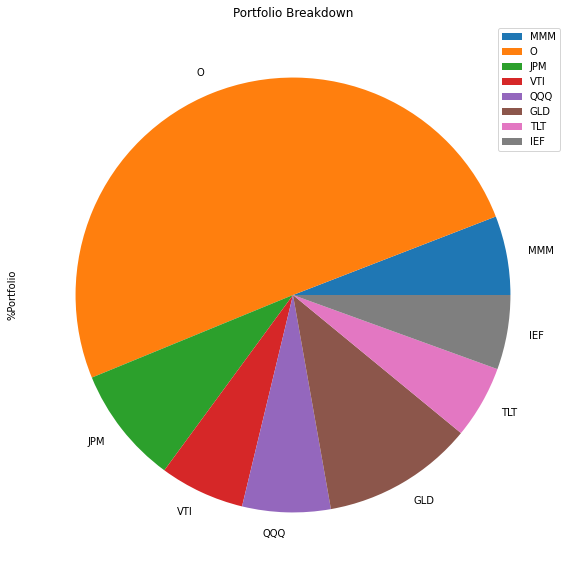

In [4]:
portfolio['%Portfolio'].plot(kind='pie',
                             title='Portfolio Breakdown',
                             figsize=(10, 10),
                             legend=True)

In [5]:
portfolio = portfolio.style.applymap(questrade.color_negative_red, subset=['Gain/Loss (%)'])
portfolio

,Description,Currency,Quantities,Market Value,Gain/Loss (%),%Portfolio
Symbol,,,,,,
MMM,3M COMPANY,USD,3,606.600000,2.700000,1.900000
O,REALTY INCOME CORP,USD,75,5205.000000,13.400000,16.270000
JPM,JPMORGAN CHASE & CO.,USD,6,901.140000,-2.130000,2.820000
VTI,VANGUARD INDEX FUNDS VANGUARD TOTAL STOCK MARKET ETF,USD,3,651.630000,11.000000,2.040000
QQQ,INVESCO QQQ TRUST UNIT SER 1,USD,2,678.840000,6.180000,2.120000
GLD,SPDR GOLD TRUST GOLD SHARES NPV,USD,7,1164.800000,-4.530000,3.640000
TLT,ISHARES TRUST BARCLAYS 20+ TREAS BD FD TO 07/01/2013,USD,4,560.240000,-7.650000,1.750000
IEF,ISHARES TRUST BARCLAYS 7-10 YEAR TREASURY BOND ETF,USD,5,572.550000,-3.480000,1.790000


## Monthly Dividend Income

In [6]:
div = questrade.get_dividend_income()
div.loc['Total'] = div.sum(numeric_only=True, axis=0)
div

HTTPError: 401 Client Error: Unauthorized for url: https://api03.iq.questrade.com/v1/accounts/51802566/activities?startTime=2020-05-01T00%3A00%3A00-05%3A00&endTime=2020-05-31T00%3A00%3A00-05%3A00

In [ ]:
div[:-1].plot(kind='bar',
                    title='Monthly Dividend Payments',
                    xlabel='Months',
                    ylabel='Dividend ($)',
                    figsize=(15, 10),
                    legend=False,
                    ylim=(0, 30))

## Global Macro Momentum

In [ ]:
global_macro = ['SPY', 'QQQ', 'TLT', 'IEF', 'GLD', 'DBC']
period = [1,3,6,12,24,36,48,60]

data = {'Symbol': [], 'Momentum': []}
count = 0
for symbol in global_macro:
    count += 1
    print(f"{count}/{len(global_macro)}")
    data['Symbol'].append(symbol)
    data['Momentum'].append(momentum.calculate_equal_weight_momentum(symbol, period))
momentum_df = pd.DataFrame(data)
momentum_df.set_index('Symbol')
momentum_df.sort_values(by='Momentum',inplace=True, ascending=False)
momentum_df

## US Sector Momentum

In [ ]:
sector_df = pyticker.get_sector_df()
period = [1,3,6,12]
count = 0
for x in list(sector_df.index):
    count += 1
    print(f"{count}/{len(list(sector_df.index))}")
    sector_df.loc[x,'Momentum'] = momentum.calculate_equal_weight_momentum(x, period)

In [ ]:
sector_df.sort_values(by='Momentum', inplace=True, ascending=False)
sector_df

## Dow Jones Equity Momentum

In [7]:
symbols = pyticker.get_symbols_by_index('DOW JONES')

data = {'Symbol': [], 'Momentum': []}
count = 0
for symbol in symbols:
    count += 1
    print(f"{count}/{len(symbols)}")
    data['Symbol'].append(symbol)
    try:
        data['Momentum'].append(momentum.calculate_equal_weight_momentum(symbol, [1,3,6,12,24,36]))
    except:
        data['Momentum'].append(0)

df = pd.DataFrame(data)
df.set_index('Symbol', inplace=True)
df

1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30


,Momentum
Symbol,
MMM,0.143686
AXP,0.378711
AAPL,0.761379
BA,0.189279
CAT,0.582994
CVX,0.221460
CSCO,0.225970
KO,0.151541
GS,0.538932


In [8]:
df = df.sort_values(by='Momentum', ascending=False)
df

,Momentum
Symbol,
AAPL,0.761379
CAT,0.582994
MSFT,0.574733
GS,0.538932
DIS,0.493839
JPM,0.453991
HD,0.440559
UNH,0.380471
NKE,0.380171


In [22]:
top_three = df.head(5)
top_three

,Momentum
Symbol,
AAPL,0.761379
CAT,0.582994
MSFT,0.574733
GS,0.538932
DIS,0.493839


In [23]:
top_three_copy = top_three.copy()
for symbol in top_three.index:
    top_three_copy.loc[symbol,'Dividend_Growth'] = dividend.calcualte_avg_dividend_growth(symbol,5)
    top_three_copy.loc[symbol,'Dividend_Yield'] = dividend.calculate_current_dividend_yield(symbol)
    top_three_copy.loc[symbol,'Current_Price'] = price.get_current_price(symbol)
    top_three_copy.loc[symbol,'12M_High'] = price.calculate_prev_max_high(symbol,252)
    top_three_copy.loc[symbol,'3M_Low'] = price.calculate_prev_min_low(symbol,60)
    top_three_copy.loc[symbol,'6M_Low'] = price.calculate_prev_min_low(symbol,120)
    top_three_copy.loc[symbol,'12M_Avg'] = (price.calculate_prev_max_high(symbol,252)+price.calculate_prev_min_low(symbol,252))/2
    top_three_copy.loc[symbol,'12M_Low'] = price.calculate_prev_min_low(symbol,252)
        
top_three_copy

,Momentum,Dividend_Growth,Dividend_Yield,Current_Price,12M_High,3M_Low,6M_Low,12M_Avg,12M_Low
Symbol,,,,,,,,,
AAPL,0.761379,0.097703,0.006012,134.320007,145.089996,116.209999,107.320000,106.903748,68.717499
CAT,0.582994,0.070913,0.017904,230.110001,237.779999,179.339996,149.630005,169.000000,100.220001
MSFT,0.574733,0.101517,0.008003,261.149994,261.779999,224.259995,199.619995,215.584999,169.389999
GS,0.538932,0.148696,0.014734,339.350006,356.850006,270.619995,185.520004,261.105003,165.360001
DIS,0.493839,0.153016,0.009398,183.020004,203.020004,160.520004,117.230003,150.940002,98.860001
